# Topic modeling *Rodong Sinmun* and comparing with data from *Choson Munhak*

## 1. Topic modeling on *Rodong Sinmun*

### 1.1. Preprocessing

If the preprocessed data is available, this part can be skipped.

In [5]:
from konlpy.tag import Komoran
import os
import re
import pandas as pd
komoran = Komoran()

In [ ]:
pos_filter = ['VV', 'VA', 'NNG', 'NNP', 'MAG', 'NA', 'SN', 'XR']

def filter_content(sentences):
    tagged_content = []
    filtered_content = []
    for sentence in sentences:
        if sentence.isspace() or not sentence:
            continue
        try:
            tagged = komoran.pos(sentence)
            filtered = [pos[0] for pos in tagged if pos[1] in pos_filter and (len(pos[0]) > 1)]
            tagged_content.append(tagged)
            filtered_content.append(' '.join(filtered))
        except Exception as e:
            print("Error parsing: %s" % sentence)
            print(e)
            pass
    return tagged_content, filtered_content


In [ ]:
def clean_non_korean_characters(text):
    return re.sub(r'[^\uac00-\ud7a3|\u0000-\u00ff]', ' ', text)

def preprocess(text):
    text = clean_non_korean_characters(text)
    tagged_content, filtered_content = filter_content(text.split('.'))
    return ' '.join(filtered_content)

In [ ]:
files = [str(s) for s in pathlib.Path('D:\\Backup\\rodong').glob("*.txt")]
rec = []
for file in files:
    if file.startswith('2017') or file.startswith('2018'):
        continue
    try:
        with open(file, 'r', encoding='utf8') as fp:
            content = ''.join(fp.read().splitlines())
    except UnicodeDecodeError:
        with open(file, 'r') as fp:
            content = ''.join(fp.read().splitlines())
        
    date = file.replace('.', '').replace('rodong', '')
    date = re.sub(r'-\d+', '', date)
    rec.append({'date': date, 'content': content})
rodong_df = pd.DataFrame(rec)
rodong_df['year'] = rodong_df['date'].apply(lambda x: ''.join([_ for _ in x if _.isdigit()][:4]))
df = rodong_df.copy()
df['text'] = rodong_df[['content','year']].groupby(['year'])['content'].transform(lambda x: ' '.join(x))
df = df[['year', 'text']].drop_duplicates()

In [ ]:
df2 = df.drop('text', axis=1)
df2['text'] = df['text'].apply(preprocess)
df = df2

In [ ]:
#import pickle
#with open('rodong-yearly-tokenized.pkl', 'wb') as fp:
#    pickle.dump(df2, fp)

### 1.2. Loading pre-saved data

In [1]:
import pickle
with open('rodong-yearly-tokenized.pkl', 'rb') as fp:
    df = pickle.load(fp)

Our text is aggregated at the yearly level (each year contains the concatenated text for all issues from that year). This is less than optimal for topic modelling, however the structure of the original dataset made this aggregation the most practical solution. We remedy this problem by splitting the text of each year into chunks of 5000 characters.

In [2]:
documents = []
n = 5000
index = 0
mapping = {}
for i, row in df.iterrows():
    text = row['text']
    documents += [text[i:i+n] for i in range(0, len(text), n)]
    for j in  range(0, len(text), n):
        mapping[index + j] = row['year']
    index += j + 1

### 1.3. Topic modelling

In [3]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(max_df=1.0, min_df=0.1, max_features=3000, stop_words=['로이', '하', '는', '은', '를', '가', '이', '을', '하시', '머니', '리당', ''])
X = vectorizer.fit_transform([re.sub('\.*께', '', _) for _ in documents])
nmf = NMF(n_components=20, init = 'nndsvd').fit(X)
display_topics(nmf, vectorizer.get_feature_names(), 50)

Topic 0:
혁명, 사회주의, 사상, 위대, 인민, 건설, 군대, 승리, 주체, 정신, 령도, 단결, 위력, 력사, 신념, 시대, 위하, 위업, 수령, 사회, 투쟁, 발전, 높이, 강화, 일심, 오늘, 강성대국, 백두, 나라, 창조, 조국, 인민군대, 대중, 경제, 군사, 전진, 기치, 정치, 시련, 경애, 자주, 강국, 로작, 선군정치, 새롭, 주체사상, 민족, 당원, 세기, 수뇌부
Topic 1:
미국, 나라, 이라크, 대하, 지역, 세계, 이란, 싸이, 보도, 정부, 의하, 씨야, 최근, 위하, 국제, 유엔, 미군, 인권, 문제, 밝히, 행위, 경제, 사회, 대통령, 중국, 위협, 통신, 발표, 방위, 조치, 평화, 정책, 반대, 회의, 신문, 국가, 발생, 간섭, 조선중앙, 핵무기, 개발, 비난, 군사, 전략, 강화, 계속, 제재, 계획, 주장, 주민
Topic 2:
생산, 공장, 기술, 일군, 직장, 설비, 기업소, 공정, 동자, 위하, 혁신, 기술자들, 동계, 현대, 전력, 석탄, 높이, 탄광, 제품, 계획, 공업, 경제, 과학기술, 원료, 부문, 수행, 보장, 성과, 기계, 종업원, 단위, 가공, 비롯, 증산, 수준, 늘이, 사업, 벌리, 발전, 기술자, 투쟁, 광산, 자체, 생산자, 목표, 기지, 과학, 제작, 창조, 관리
Topic 3:
민족, 통일, 선언, 조국, 공동, 자주, 겨례, 단합, 겨레, 남조선, 홍일, 외세, 위하, 단결, 애국, 운동, 평화, 화해, 동포, 총련, 해외, 실현, 민속, 애족, 력사, 민중, 관계, 조선, 기치, 단체, 세력, 대결, 발표, 성명, 협력, 시대, 문제, 당국, 이룩, 번영, 책동, 내외, 합치, 투쟁, 상봉, 대하, 평양, 만족, 본부, 의지
Topic 4:
남조선, 괴뢰, 당국, 보수, 사건, 대결, 동족, 인권, 집권, 정권, 대하, 세력, 선거, 소동, 규탄, 관계, 미국, 단체, 도발, 망동, 민심, 모략, 언론, 공화국, 인민, 행위, 통일, 각계, 위하, 민주, 외세, 대화, 범죄, 

## 2. Interpretation

### 2.1. Topic labelling

In [7]:
topics = ['Politics', 'Foreign Affairs', 'Industry', 'Nation', 'South Korea', 'Family', 'Leaders', 'Leaders', 'Leaders', 'Agriculture',
         'Youth', 'Japan', 'Leaders', 'War', 'Sports', 'Leaders', 'Education', "Workers Party", 'Construction', '?']

### 2.2. Dominant topic statistics

In [8]:
nmf_output = nmf.transform(X)

In [9]:
import numpy as np
topic_res = pd.DataFrame(np.round(nmf_output, 2), columns=topics, index=list(mapping.values()))
topic_res['dominant_topic'] = [topic_res.columns[max] for max in np.argmax(topic_res.values, axis=1)]
topic_res

,Politics,Foreign Affairs,Industry,Nation,South Korea,Family,Leaders,Leaders,Leaders,Agriculture,...,Japan,Leaders,War,Sports,Leaders,Education,Workers Party,Construction,?,dominant_topic
2016,0.05,0.00,0.04,0.00,0.00,0.00,0.04,0.01,0.00,0.01,...,0.00,0.00,0.01,0.02,0.00,0.02,0.00,0.02,0.0,Politics
2016,0.00,0.00,0.01,0.06,0.01,0.00,0.04,0.02,0.00,0.00,...,0.01,0.01,0.02,0.00,0.06,0.00,0.00,0.00,0.0,Nation
2016,0.01,0.00,0.00,0.01,0.00,0.01,0.03,0.00,0.01,0.00,...,0.01,0.03,0.00,0.00,0.10,0.01,0.02,0.00,0.0,Leaders
2016,0.00,0.00,0.00,0.05,0.00,0.00,0.12,0.00,0.00,0.00,...,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.0,Leaders
2016,0.01,0.00,0.00,0.02,0.00,0.00,0.08,0.02,0.00,0.00,...,0.03,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.0,Leaders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,0.00,0.00,0.02,0.00,0.00,0.02,0.11,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.01,0.0,Leaders
2015,0.02,0.00,0.06,0.00,0.00,0.02,0.02,0.00,0.01,0.00,...,0.00,0.03,0.00,0.01,0.01,0.01,0.01,0.01,0.0,Industry
2015,0.00,0.01,0.02,0.01,0.00,0.02,0.01,0.01,0.01,0.00,...,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.08,0.0,Construction
2015,0.00,0.05,0.00,0.02,0.04,0.00,0.01,0.01,0.01,0.00,...,0.04,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.0,Foreign Affairs


In [10]:
topic_res['dominant_topic'].value_counts()

Leaders            11466
Foreign Affairs     4209
Industry            4140
Nation              4018
Family              2857
Agriculture         2235
South Korea         2179
Politics            2060
Workers Party       2014
Japan               1907
War                 1570
Construction        1417
Education           1296
Sports              1181
Youth                961
?                    901
Name: dominant_topic, dtype: int64

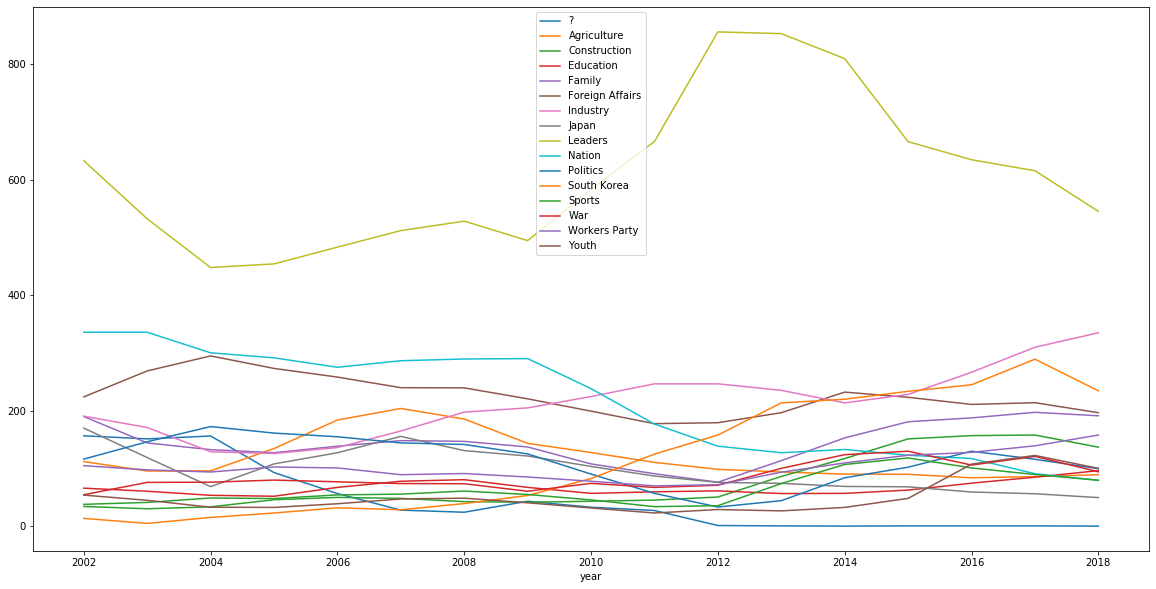

In [11]:
%matplotlib inline
line_colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
topic_res['year'] = topic_res.index
out = pd.pivot_table(topic_res[['dominant_topic']], index=topic_res.year, columns=topic_res.dominant_topic, aggfunc='count').fillna(0)
out.columns = out.columns.droplevel(0)
mva = out.rolling(window=3).mean()
mva.columns.name = None 
mva = mva.reindex(sorted(mva.columns), axis=1)
ax = mva.plot(figsize=(20,10),color=line_colors,x_compat=True)
#plt.xticks(range(0,len(mva.index)), mva.index, rotation = 'vertical')
pass

## 3. Agriculture topic

### 3.1. Plotting evolution of agriculture topic 

We rely here on topics weights rather than dominant topic (the dominant topic statistic is less meaningful since we chunked the corpus randomly rather than by newspaper issue or by article)

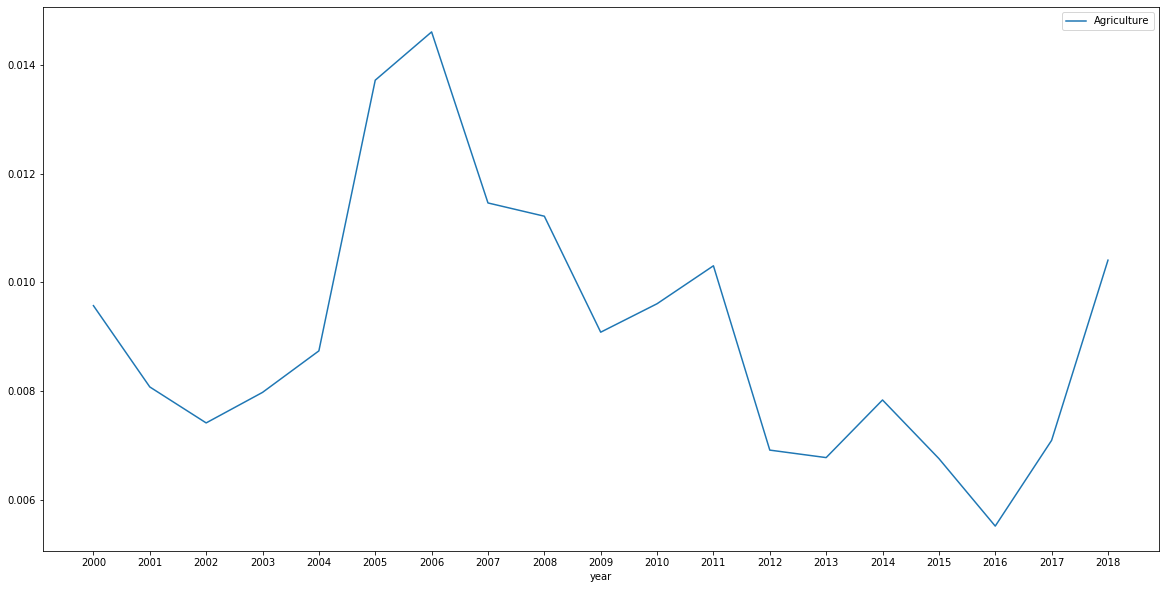

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
topic_res['year'] = topic_res['year'].astype(int)
dd = topic_res[['year', 'Agriculture']].groupby('year').mean()
#plt.xticks(range(0,len(dd.index)), dd.index, rotation = 'vertical')
dd.plot(figsize=(20,10),xticks=dd.index)

## 4. Correlation with literature

### 4.1. Loading the literature data

We import the values of the evolution of the agriculture topic from our work on *Choson Munhak*

In [13]:
from collections import OrderedDict
agriculture_literature = OrderedDict({2000: 0.02194444444444445,
  2001: 0.04093023255813954,
  2002: 0.02741935483870968,
  2003: 0.03222222222222223,
  2004: 0.03411764705882354,
  2005: 0.03275,
  2006: 0.029393939393939396,
  2007: 0.029142857142857144,
  2008: 0.05612903225806453,
  2009: 0.04815789473684211,
  2010: 0.03923076923076924,
  2011: 0.03156250000000001,
  2012: 0.041162790697674416,
  2013: 0.0430952380952381,
  2014: 0.046046511627906975,
  2015: 0.034864864864864877,
  2016: 0.031315789473684214})

### 4.2. Comparison with the evolution of the agriculture topic in *Rodong Sinmun* (step 1)

Text(0, 0.5, 'Rodong Sinmun')

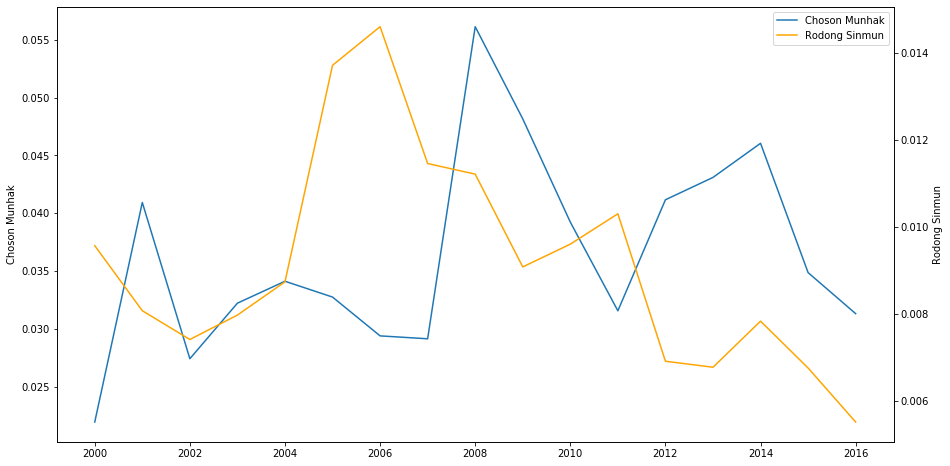

In [17]:
agriculture_rodong = OrderedDict(dd[dd.index < 2017]['Agriculture'].to_dict().items())
agdf = pd.DataFrame({'Rodong Sinmun' : agriculture_rodong, 'Choson Munhak': agriculture_literature})
ax = agdf['Choson Munhak'].plot(figsize=(15,8), legend=True)
ax.set_ylabel("Choson Munhak")
ax = agdf['Rodong Sinmun'].plot(secondary_y=True, color='orange', legend=True, mark_right=False)

ax.set_ylabel('Rodong Sinmun')

### 4.3. Evaluating the lag (Granger test)

It looks like the two time series could be linked, but with a significant time lag. We first run a Granger test to evaluate the possibility than one series "causes" the other.

In [18]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(agdf, maxlag=5)

C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0498  , p=0.8269  , df_denom=13, df_num=1
ssr based chi2 test:   chi2=0.0613  , p=0.8045  , df=1
likelihood ratio test: chi2=0.0612  , p=0.8047  , df=1
parameter F test:         F=0.0498  , p=0.8269  , df_denom=13, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1170  , p=0.8907  , df_denom=10, df_num=2
ssr based chi2 test:   chi2=0.3511  , p=0.8390  , df=2
likelihood ratio test: chi2=0.3471  , p=0.8407  , df=2
parameter F test:         F=0.1170  , p=0.8907  , df_denom=10, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6290  , p=0.6191  , df_denom=7, df_num=3
ssr based chi2 test:   chi2=3.7738  , p=0.2869  , df=3
likelihood ratio test: chi2=3.3414  , p=0.3419  , df=3
parameter F test:         F=0.6290  , p=0.6191  , df_denom=7, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7492  , p=0.6068  , df_den

C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


{1: ({'ssr_ftest': (0.049796202199303655, 0.8268864084489169, 13.0, 1),
   'ssr_chi2test': (0.061287633476066035, 0.8044722374040908, 1),
   'lrtest': (0.06117055192822818, 0.8046553102497467, 1),
   'params_ftest': (0.04979620219930387, 0.8268864084489169, 13.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.11704823462829134, 0.8907431020841935, 10.0, 2),
   'ssr_chi2test': (0.351144703884874, 0.8389766933840461, 2),
   'lrtest': (0.34709765540276294, 0.8406761018780573, 2),
   'params_ftest': (0.11704823462829178, 0.8907431020841935, 10.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.6289685462839214, 0.619067771933314, 7.0, 3),
   'ssr_chi2test': (3.7738112777035284, 0.28694704917752456, 3),
   'lrtest': (3.341362748628484, 0.34192708671686484, 3),
   'params_ftest': (0.6289685462839206, 0.6190677719333147, 7.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

And we are unable to prove a significant Granger causality relationship.

### 4.4. Evaluating the lag (Cross-correlation)

We look at the series' cross correlation next.

Text(0.5, 0, 'Lag')

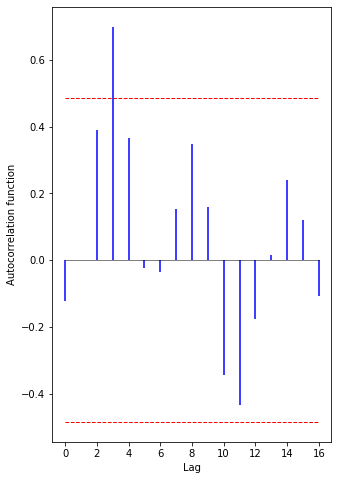

In [20]:
from statsmodels.tsa.stattools import ccf

choson_munhak_agr = np.array(list(agriculture_literature.values()))
rodong_sinmun_agr = np.array(list(agriculture_rodong.values()))
lags= choson_munhak_agr.shape[0]
sl = 2 / np.sqrt(lags)

plt.subplots(figsize=(5,8))
plt.plot(list(np.ones(lags) * sl), color='r', linewidth=1, linestyle='dashed')
plt.plot(list(np.ones(lags) * -sl), color='r', linewidth=1, linestyle='dashed')
plt.plot([0]*lags, color='black', linewidth=0.5)

for i, value in enumerate(ccf(choson_munhak_agr, rodong_sinmun_agr)[:lags]):
    plt.vlines(i, ymax=value, ymin=0, color = 'b')
#plt.bar(list(range(0, 17)), ccf(choson_munhak_agr, rodong_sinmun_agr), align='edge')
plt.ylabel("Autocorrelation function")
plt.xlabel("Lag")

And we find a significant (positive) autocorrelation at a 3 year lag, meaning that an increase in volume of discourse on agriculture in *Rodong Sinmun* influences the volume of discourse on agriculture in *Choson Munhak* with a 3 year lag.

### 4.5. Plotting the 3 year lag

In [21]:
offset_agriculture_literature = {k-3: v for k,v in agriculture_literature.items() if k > 2002}
cut_agriculture_rodong = {k: v for k,v in agriculture_rodong.items() if k < 2014}

import scipy
scipy.stats.pearsonr(list(cut_agriculture_rodong.values()), list(offset_agriculture_literature.values()))

(0.7443791185993391, 0.0022621047594663)

Text(0, 0.5, 'Rodong Sinmun')

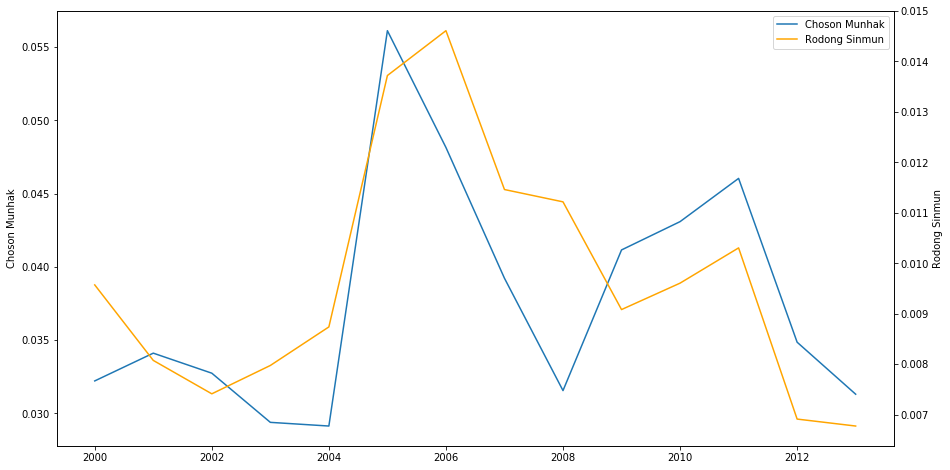

In [22]:
agdf = pd.DataFrame({'Rodong Sinmun' : cut_agriculture_rodong, 'Choson Munhak': offset_agriculture_literature})
ax = agdf['Choson Munhak'].plot(figsize=(15,8), legend=True)
ax.set_ylabel("Choson Munhak")
ax = agdf['Rodong Sinmun'].plot(secondary_y=True, color='orange', legend=True, mark_right=False)

ax.set_ylabel('Rodong Sinmun')